# 3D Protein Pose Recovery - Robustness to Unseen Protein

Through the following model, we consider that a cryo-EM measurement (i.e. 2D projection) $\mathbf{y}_i \in \mathbb{R}^{M}$ is acquired through
\begin{equation}
\label{eq:linear-forward-model}
\mathbf{y}_i={\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x+\mathbf n,
\end{equation}
where $\mathbf x \in \mathbb{R}^{V}$ is the unknown 3D density map [*DiMaio et al.*](https://academic.oup.com/bioinformatics/article/23/21/2851/374177) (Coulomb potential). The operator $\mathbf P_{\theta_i}: \mathbb R^V \to \mathbb R^M$ is the projection along the 3D pose $\theta_i$ (i.e., the x-ray transform). The operator $\mathbf S_\mathbf{t}: \mathbb R^M \to \mathbb R^M$ is a shift of the projection by $\mathbf{t}=(t_1, t_2)$. The convolution operator $\mathbf {C}_{\boldsymbol\varphi}: \mathbb R^M \to \mathbb R^M$ models the microscope contrast transfer function (CTF) with parameters $\boldsymbol\varphi=(d_1, d_2, \alpha_{\rm ast})$, that are, respectively, the defocus-major, the defocus-minor and the angle of astigmatism. Finally, $\mathbf n \in \mathbb{R}^{M}$ represents an additive noise. Our goal is then to recover the angles $\theta_i$ from every projection $\mathbf y_i$. 

Final **goal**: We have $N$ protein 3D volumes that are used to create the training set of 2D projections $\{\mathbf y_{N, i}^{train}\}$. Another, unseen protein 3D volume $\mathbf x^{test}$ is used to create the test set of 2D projections $\{\mathbf y_i^{test}\}$. The set of projections is created using the projection $\mathbf P_{\theta_i}$ along the 3D pose $\theta_i$ as well as all the other operators (noise $\mathbf n$, CTF $\mathbf C_\varphi$, shift $\mathbf S_{\mathbf t}$) specified in the equation above. 


  $\{\mathbf x_1^{train}, ..., \mathbf x_N^{train}\}  \rightarrow \{\mathbf y_{N, i}^{train}\} = \{{\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x_N^{train}+\mathbf n\}$
  

  $\mathbf x^{test} \rightarrow \{\mathbf y_i^{test}\} =\{{\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x^{test}+\mathbf n\}$

[Only one - 5j0n](http://0.0.0.0:8080/notebooks/notebooks/1-phase1/limited3.14_angle_recovery_with_estimated_distances.ipynb)

In [15]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [3]:
import sys
sys.path.append("..") 
from cryoem.projections import generate_2D_projections
from cryoem.plots import plot_projection, plot_detector_pixels, plot_angles_count
from cryoem.preprocessing import preprocessing, train_val_test_split
from cryoem.distance_estimation import train_distance_estimation
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl, Adam
from cryoem.conversions import quaternion2euler
import matplotlib.pyplot as plt
from cryoem.conversions import d_q, euler2quaternion
from cryoem.reconstruction import reconstruct
from cryoem.plots import plot_dP_dQ, plot_5_projections_for_every_protein
import h5py
import ipyvolume as ipv
import numpy as np
import pathlib
import tensorflow as tf
from tensorflow.python.client import device_lib 
# from numba import cuda
tf.__version__

'2.0.0'

In [4]:
!echo $CUDA_VISIBLE_DEVICES

0


In [5]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1666222773871733344
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10340837530380152295
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15309798328448891804
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2704015360
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10928532128176118442
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [6]:
!which python

/home/jelena/miniconda3/envs/protein_reconstruction/bin/python


## (1) Generate Sythetic Data

In [7]:
MRC_DIR         = "/home/jelena/MRC"  #"/mnt/scratch/students/MRC"
RESULTS_DIR     = "/home/jelena/Desktop/protein-reconstruction/data/5a1a_robustness_to_unseen_proteins_2105"#"/home/jelena/data"  #"/mnt/scratch/students"
pathlib.Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

#### Asymmetric proteins - C1 (this is the symmetry of 5j0n protein)

In [8]:
############
NUM_TRAIN_PROTEINS = 4
NUM_TEST_PROTEINS  = 1

PROTEINS  = [#'4usn.mrc', 
#              '5nvu.mrc',
#              '5nvs.mrc',
#              '6mem.mrc',
#              '6o1o.mrc',
              
#              '5j0n.mrc',
             #'6o1o.mrc',
             #'6ran.mrc',
             
             ]
# PROTEINS = ['5j0n.mrc', 
#             '5j0n.mrc',
#             '5j0n.mrc',
#             '5j0n.mrc',
#             '5j0n.mrc']
PROTEINS = [
    '6drv.mrc',
    '6cvm.mrc',
    '1f4a.mrc',
    '1f4h.mrc',
    #'5a1a.mrc',
]

PROTEINS = list(map(lambda x: x[:-4], PROTEINS))

PROTEINS_TRAIN = PROTEINS[:NUM_TRAIN_PROTEINS]
PROTEINS_TEST  = PROTEINS[NUM_TRAIN_PROTEINS:NUM_TRAIN_PROTEINS+NUM_TEST_PROTEINS]

In [9]:
# 2.0, 1.0, 1.0 - 1/2 - 5j0n
# 2.0, 0.5, 1.0 - 1/2
# 2.0, 0.4, 2.0 - used when one

# 2.0, 1.0, 2.0 - 1
# 2.0, 1.0, 0.5 - 1/4 - 5a1a

In [10]:
PROJECTIONS_NUM_SINGLE = 1000
# ang1, ang2, ang3(=inplane rotation)
# ANGLE_COVERAGE  = [2.0, 0.4, 2.0]  # 5j0n
ANGLE_COVERAGE = [2.0, 1.0, 0.4] #[1.0, 1.0, 2.0] #[2.0, 1.0, 0.5 ]  # 5a1a
ANGLE_SHIFT     = [0., 0., 0.]

In [11]:
#IMG_DIM = 64
NOISE_VAR_SCALE = 0   # it takes max px value to be the variance, since all proteins have it different
TRANSLATION = 0
CHANNELS = 1
DTYPE = np.float32

In [12]:
ANGLE_COVERAGE

[2.0, 1.0, 0.4]

In [13]:
ANGLE_SHIFT

[0.0, 0.0, 0.0]

In [14]:
# generate sythetic data - 2D projections and their corresponding orientations from a given 3D protein
for protein in PROTEINS_TRAIN + PROTEINS_TEST: 
    generate_2D_projections(input_file_path=f"{MRC_DIR}/{protein}.mrc", 
                            ProjNber=PROJECTIONS_NUM_SINGLE,
                            AngCoverage=ANGLE_COVERAGE,
                            AngShift=ANGLE_SHIFT,
                            Angles=None, #np.load(f"{RESULTS_DIR}/custom_true_angles.npy"), #np.load(f"{RESULTS_DIR}/custom_true_angles.npy"),
                            angles_gen_mode="uniform_S2",#"uniform_angles",
                            output_file_name=f"{RESULTS_DIR}/{protein}_uniformS2_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_SHIFT))}.h5",  #f"{RESULTS_DIR}/{protein}_given.h5",  
                            dtype=DTYPE)
    #cuda.current_context().reset() 

* Generating the dataset *
(1000, 3)
Protein:         6drv
Input filename:  /home/jelena/MRC/6drv.mrc
Output filename: /home/jelena/Desktop/protein-reconstruction/data/5a1a_robustness_to_unseen_proteins_2105/6drv_uniformS2_ProjectionsAngles_ProjNber1000_AngCoverage2.0,1.0,0.4_AngShift0.0,0.0,0.0.h5
Volume:          (71, 102, 127)
Projections (#): (1000, 177, 177)
Angles (#):      (1000, 3)

**********
* Generating the dataset *
(1000, 3)
Protein:         6cvm
Input filename:  /home/jelena/MRC/6cvm.mrc
Output filename: /home/jelena/Desktop/protein-reconstruction/data/5a1a_robustness_to_unseen_proteins_2105/6cvm_uniformS2_ProjectionsAngles_ProjNber1000_AngCoverage2.0,1.0,0.4_AngShift0.0,0.0,0.0.h5
Volume:          (72, 102, 127)
Projections (#): (1000, 178, 178)
Angles (#):      (1000, 3)

**********
* Generating the dataset *
(1000, 3)
Protein:         1f4a
Input filename:  /home/jelena/MRC/1f4a.mrc
Output filename: /home/jelena/Desktop/protein-reconstruction/data/5a1a_robustness_to_uns

In [15]:
# location of *.h5 files
#data_dir = "../../data/"

# half coverage (AngCoverage=0.5)
#projections_filename = "5j0n_uniform_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File("/home/jelena/Desktop/protein-reconstruction/data/5a1a_robustness_to_unseen_proteins/1f4h_uniformS2_ProjectionsAngles_ProjNber1000_AngCoverage1.0,0.4,1.0_AngShift0.0,0.0,0.0.h5", 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

1000 projections of images with dimension (180, 180) pixels
1000 sets of 3 ground truth angles of corresponding projection images


In [16]:
plot_detector_pixels(data['Angles'])

In [13]:
# # read stored data for further processing
# projections_train = []  #np.empty((len(PROTEINS_TRAIN)*PROJECTIONS_NUM_SINGLE, IMG_DIM, IMG_DIM, CHANNELS), dtype=DTYPE)
# angles_true_train = []  #np.empty((len(PROTEINS_TRAIN)*PROJECTIONS_NUM_SINGLE, 3), dtype=DTYPE)

# print(f"* Train dataset *")
# for i, protein in enumerate(PROTEINS_TRAIN):
#     data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
#     projections = np.array(data['Projections'])
#     angles_true = np.array(data['Angles'])
    
#     print(f"--- protein: {protein} ---")
#     print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
#     print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")

#     projections = preprocessing(projections, rescale_dim=IMG_DIM, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=CHANNELS)
   
#     projections_train.extend(projections)
#     angles_true_train.extend(angles_true)

# projections_test = []  #np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, IMG_DIM, IMG_DIM, CHANNELS), dtype=DTYPE)
# angles_true_test = []  #np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, 3), dtype=DTYPE)

# print(f"\n* Test dataset *")
# for i, protein in enumerate(PROTEINS_TEST):
#     data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
#     projections = np.array(data['Projections'])
#     angles_true = np.array(data['Angles'])
    
#     print(f"--- protein: {protein} ---")
#     print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
#     print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")
    
#     projections = preprocessing(projections, rescale_dim=IMG_DIM, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=CHANNELS)
    
#     projections_test.extend(projections)
#     angles_true_test.extend(angles_true)
    

In [14]:
# projections_train = np.array(projections_train).astype(DTYPE)
# angles_true_train = np.array(angles_true_train).astype(DTYPE)

# projections_test = np.array(projections_test).astype(DTYPE)
# angles_true_test = np.array(angles_true_test).astype(DTYPE)

In [14]:
#PROJECTIONS_NUM_SINGLE = 1000
# read stored data for further processing
projections_train = np.empty((len(PROTEINS_TRAIN)*PROJECTIONS_NUM_SINGLE, IMG_DIM, IMG_DIM, CHANNELS), dtype=DTYPE)
projections_train_original = []
angles_true_train = np.empty((len(PROTEINS_TRAIN)*PROJECTIONS_NUM_SINGLE, 3), dtype=DTYPE)

print(f"* Train dataset *")
i = 0
while i < len(PROTEINS_TRAIN):
    protein = PROTEINS_TRAIN[i]
    print(f"--- protein: {protein} ---")
    
    data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
    #data = h5py.File(f"{RESULTS_DIR}/{protein}_given.h5", 'r')
    
    projections = np.array(data['Projections'], dtype=np.float32)
    projections_train_original.append(projections.astype(DTYPE))
    if np.min(projections) - np.max(projections) == 0: 
        print("Data corrupted - projections")
        PROTEINS_TRAIN.remove(protein)
        continue
    angles_true = np.array(data['Angles'], dtype=np.float32)

    if np.isnan(angles_true).any(): 
        print("Data corrupted - angles")
        PROTEINS_TRAIN.remove(protein)
        continue
    
    
    print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
    print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")

    projections = preprocessing(projections, rescale_dim=IMG_DIM, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=CHANNELS)
   
    projections_train[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = projections.astype(DTYPE)
    angles_true_train[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = angles_true.astype(DTYPE)
    
    i += 1

#PROJECTIONS_NUM_SINGLE = 5000
projections_test = np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, IMG_DIM, IMG_DIM, CHANNELS), dtype=DTYPE)
projections_test_original = []
angles_true_test = np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, 3), dtype=DTYPE)

print(f"\n* Test dataset *")
i = 0
while i < len(PROTEINS_TEST):
    protein = PROTEINS_TEST[i]
    print(f"--- protein: {protein} ---")
    
    data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
    #data = h5py.File(f"{RESULTS_DIR}/{protein}_given.h5", 'r')
    projections = np.array(data['Projections'], dtype=np.float32)
    projections_test_original.append(projections.astype(DTYPE))
    
    if np.isnan(projections).any() or (np.min(projections) - np.max(projections) == 0): 
        print("Data corrupted - projections")
        PROTEINS_TEST.remove(protein)
        continue
    angles_true = np.array(data['Angles'], dtype=np.float32)

    if np.isnan(angles_true).any(): 
        print("Data corrupted - angles")
        PROTEINS_TEST.remove(protein)
        continue
    
    
    print(f"{projections_test.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
    print(f"{angles_true_test.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")
    
    projections = preprocessing(projections, rescale_dim=IMG_DIM, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=CHANNELS)
    
    projections_test[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = projections.astype(DTYPE)
    angles_true_test[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = angles_true.astype(DTYPE)
    
    i += 1

NameError: name 'IMG_DIM' is not defined

In [16]:
projections_train_original[0].shape

(1000, 177, 177)

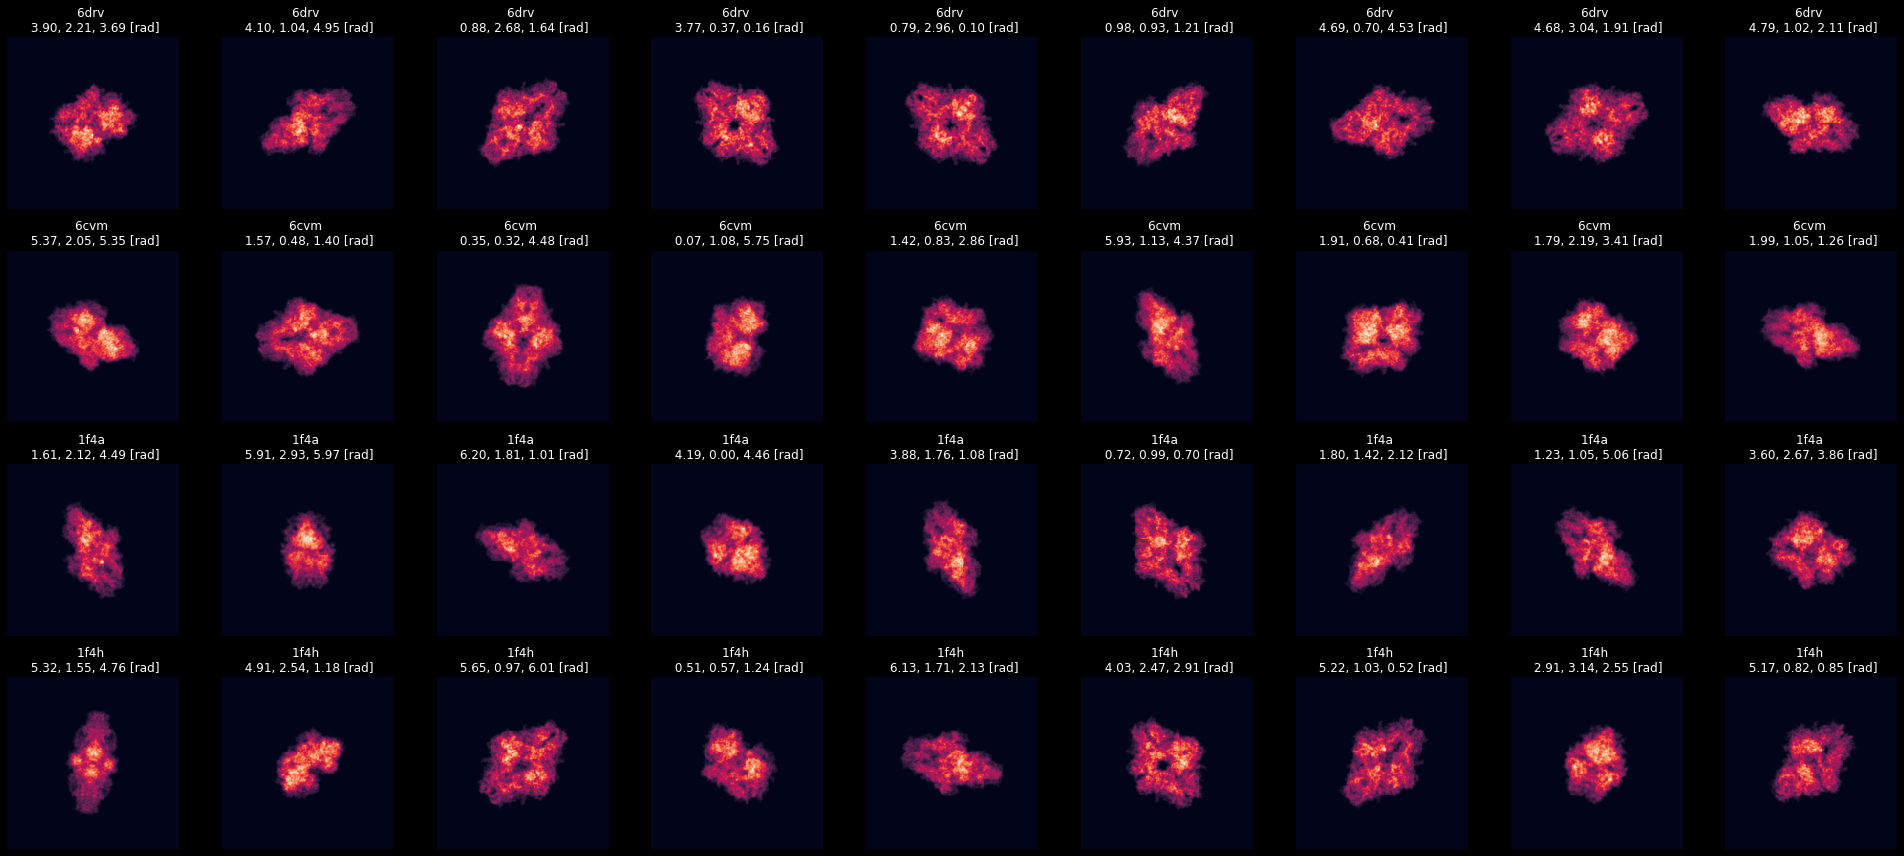

In [17]:
plot_5_projections_for_every_protein(PROTEINS_TRAIN, projections_train_original, angles_true_train)

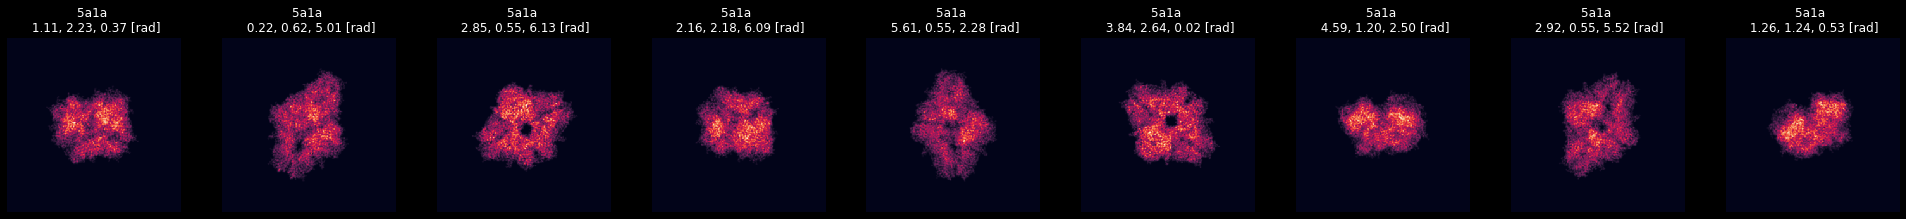

In [18]:
plot_5_projections_for_every_protein(PROTEINS_TEST, projections_test_original, angles_true_test)

In [19]:
NUM_TRAIN_PROTEINS = len(PROTEINS_TRAIN)
NUM_TEST_PROTEINS  = len(PROTEINS_TEST)
print(PROTEINS_TRAIN)
print(PROTEINS_TEST)

['6drv', '6cvm', '1f4a', '1f4h']
['5a1a']


In [20]:
projections_test.shape

(1000, 64, 64, 1)

In [21]:
# plot_projection(np.squeeze(projections_test[1000]).astype(np.float32), angles=angles_true_test[0])

In [22]:
type(projections_train[0][0][0][0])

numpy.float16

In [23]:
from cryoem.plots import plot_detector_pixels, plot_rotvec

In [24]:
plot_detector_pixels(angles_true_test)

In [32]:
ipv.screenshot()

Output()

In [25]:
plot_rotvec(angles_true_test)

ERROR! Session/line number was not unique in database. History logging moved to new session 254


In [31]:
ipv.screenshot()

Output()

ERROR! Session/line number was not unique in database. History logging moved to new session 255


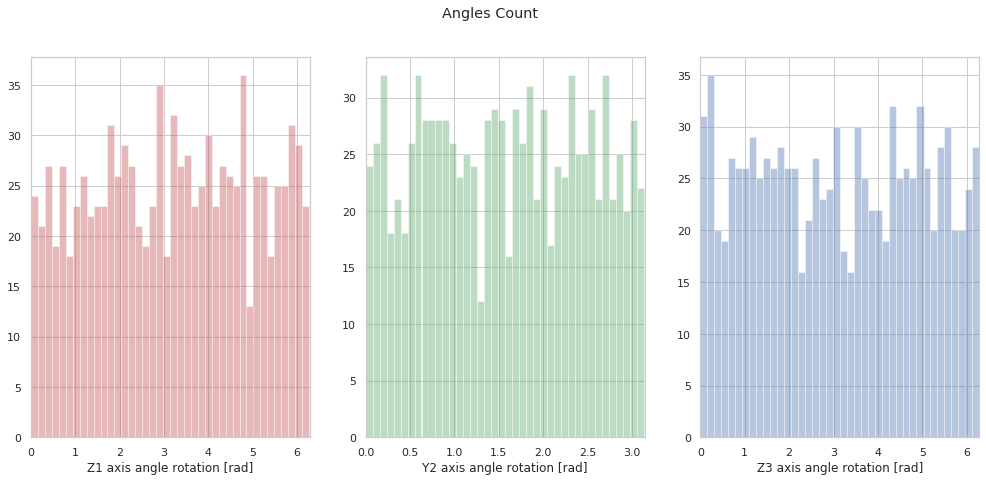

In [26]:
plot_angles_count(np.array(angles_true_test))

## (2) Distance Learning

In [27]:
PROJECTIONS_NUM = NUM_TRAIN_PROTEINS * PROJECTIONS_NUM_SINGLE
PROJECTIONS_NUM

4000

In [28]:
############
DE_LOGS_DIR = f"{RESULTS_DIR}/distance_estimation"

DE_DESCRIPTION = "5a1a_full_pipeline_unseen_proteins_given"  #"full_pipeline_seen_proteins_given"  #"full_pipeline_unseen_proteins_given"

In [29]:
train_idx, val_idx, test_idx, train_pairs_num, val_pairs_num = train_val_test_split(PROJECTIONS_NUM, test_size=0.0001, val_size=0.35, train_percent=0.001, val_percent=0.001, indices_file="")

TRAIN: 1.00 x 0.65 = 0.65 =>  2599 imgs => max pairs:    6754801   |   6754
TEST :             0.0001 =>     1 imgs => max pairs:          1   |   all
VAL  : 1.00 x 0.35 = 0.35 =>  1400 imgs => max pairs:    1960000   |   1960
Indices stored in 


Data created in 3.217165470123291 sec
Data created in 0.9284818172454834 sec
Input images shape (64, 64, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
___________________________________________________________________________________

27/27 [==============================] - 22s 805ms/step - loss: 0.4342 - mse: 0.3535 - val_loss: 0.6002 - val_mse: 0.5581
Epoch 40/100
27/27 [==============================] - 20s 753ms/step - loss: 0.4268 - mse: 0.3413 - val_loss: 0.6012 - val_mse: 0.5758
Epoch 41/100
27/27 [==============================] - 23s 858ms/step - loss: 0.4203 - mse: 0.3365 - val_loss: 0.6027 - val_mse: 0.5637
Epoch 42/100
27/27 [==============================] - 21s 787ms/step - loss: 0.4131 - mse: 0.3271 - val_loss: 0.6070 - val_mse: 0.5789
Epoch 43/100
27/27 [==============================] - 21s 795ms/step - loss: 0.4106 - mse: 0.3234 - val_loss: 0.6008 - val_mse: 0.5808
Epoch 44/100
27/27 [==============================] - 20s 736ms/step - loss: 0.4023 - mse: 0.3151 - val_loss: 0.5994 - val_mse: 0.5664
Epoch 45/100
27/27 [==============================] - 22s 824ms/step - loss: 0.3945 - mse: 0.3059 - val_loss: 0.5992 - val_mse: 0.5677
Epoch 46/100
27/27 [==============================] - 20s 749ms/step

Epoch 100/100
27/27 [==============================] - 22s 809ms/step - loss: 0.1590 - mse: 0.0678 - val_loss: 0.6054 - val_mse: 0.5855


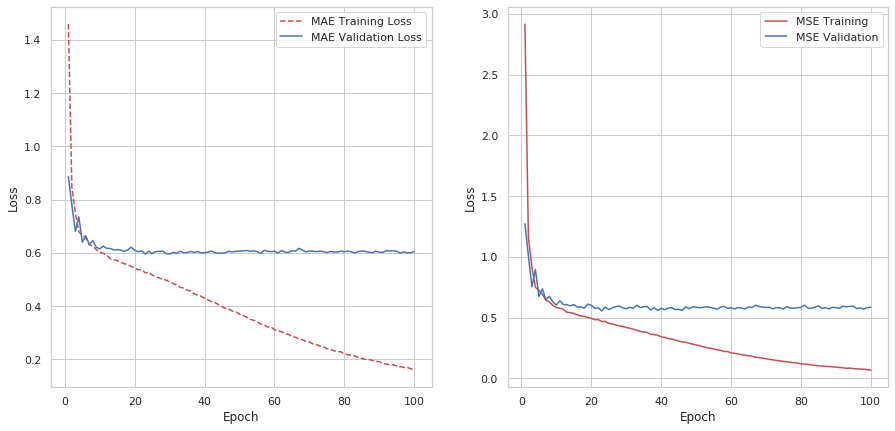

AttributeError: 'NoneType' object has no attribute 'find'

AttributeError: 'NoneType' object has no attribute 'find'

In [30]:
model, history = train_distance_estimation(X=projections_train, y=angles_true_train, 
                                           train_idx=train_idx, 
                                           val_idx=val_idx,
                                           epochs=100,
                                           batch_size=256,  #512 latest 
                                           learning_rate=1e-3, 
                                           limit_style="random", 
                                           path_logs_training=DE_LOGS_DIR, 
                                           training_description=DE_DESCRIPTION,
                                           training_steps=train_pairs_num,
                                           validation_steps=val_pairs_num, 
                                           plot=True,
                                           gpus=None)

In [33]:
# read stored model
model_filename = f"{DE_LOGS_DIR}/training/{DE_DESCRIPTION}.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [34]:
# learned distance function
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=128)

<Figure size 432x288 with 0 Axes>

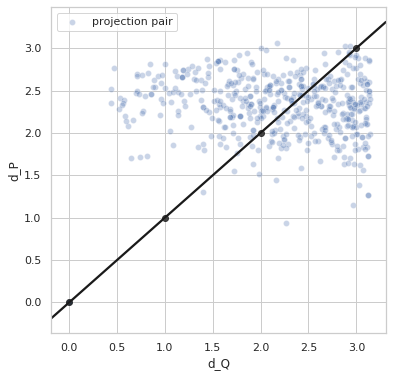

<Figure size 432x288 with 0 Axes>

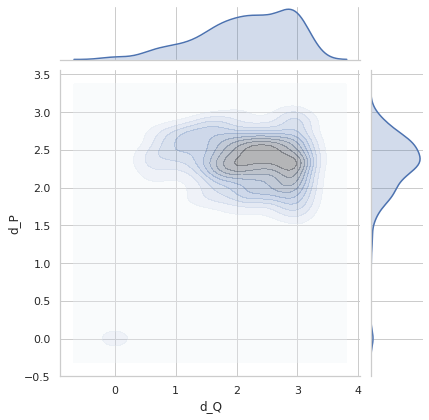

Variance = 0.8243790211648977
Min. angle recovery loss possible = 0.6782734252818403


In [35]:
# dP/dQ ratio plot
batch_size = 512
idx1 = list(np.random.choice(range(100), size=batch_size))
idx2 = list(np.random.choice(range(100), size=batch_size))

q1_true = euler2quaternion([angles_true_train[i] for i in idx1])
q2_true = euler2quaternion([angles_true_train[i] for i in idx2])

p1 = [projections_train[i] for i in idx1]
p2 = [projections_train[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

plot_dP_dQ(dP_values, dQ_values, f"{DE_LOGS_DIR}/dPdQ.png");

In [36]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

## (4) Angle Recovery

In [ ]:
from cryoem.angle_recovery import train_angle_recovery

In [ ]:
AR_LOGS_DIR = f"{RESULTS_DIR}/angle_recovery"

AR_TRAINING_DESCRIPTION = "5a1a_full_pipeline_unseen_proteins"   #"full_pipeline_seen_proteins"   #"full_pipeline_unseen_proteins" 

In [ ]:
projections_test.shape

In [ ]:
#with learning rate 20, has S shape
# now lr 5

In [ ]:
q_predicted, losses, q_all = train_angle_recovery(
    steps=50000, 
    batch_size=128, 
    in_data=projections_test, 
    distance_fn=d_p, 
    learning_rate=20, 
    limit_distance=np.pi,
    low_ang_const=ANGLE_SHIFT,
    high_ang_const=[sum(x) for x in zip(ANGLE_SHIFT, ANGLE_COVERAGE)],
    file_name=f"{AR_LOGS_DIR}/{AR_TRAINING_DESCRIPTION}",
    constraint=False
)

In [ ]:
data = np.load(f"{AR_LOGS_DIR}/{AR_TRAINING_DESCRIPTION}.npz")
q_predicted, losses, collect_data = data['arr_0'], data['arr_1'], data['arr_2']
plt.plot(data["arr_1"][:11000])

In [ ]:
angles_predicted = quaternion2euler(q_predicted)

In [ ]:
angles_predicted

---

## (5) Angle Alignment

In [ ]:
from cryoem.angle_alignment import training_angle_alignment

In [ ]:
# angles_predicted = angles_predicted.numpy().astype(np.float16)

In [ ]:
from tensorflow.keras.optimizers import Adagrad, Ftrl, Adam

In [ ]:
%matplotlib inline
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=2, 
                                                                    steps=500, 
                                                                    batch_size=256, 
                                                                    optimizer=Adam(.2),#Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                                    angles_true=angles_true_test, 
                                                                    angles_predicted=angles_predicted,
                                                                    threshold=None,
                                                                    dtype=tf.float64)

In [ ]:
from cryoem.plots import plot_iterations_rotvec

In [ ]:
%matplotlib inline
plot_iterations_rotvec(collect_data, np.array(angles_true_test), interval=1000, connections=True, selected=range(1000))

In [ ]:
%matplotlib inline
plot_iterations_rotvec(collect_data, np.zeros(angles_true_test.shape), interval=1000, connections=True, selected=range(1000))

In [ ]:
angles_true_test

In [ ]:
q_predicted_rotated =  update_quaternion(m, a_R, q_predicted, dtype=tf.float64)
angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

In [ ]:
angles_predicted_rotated

In [ ]:
from cryoem.plots import plot_iterations_polar_plot, plot_pixels_pairs

In [ ]:
%matplotlib inline
plot_iterations_polar_plot(collect_data, np.array(angles_true_test), interval=1000, connections=True, selected=range(500))

In [ ]:
plot_pixels_pairs(np.array(angles_true_test), angles_predicted, interval=1, connections=True, selected=range(100))

In [ ]:
from scipy.spatial.transform import Rotation as R

In [ ]:
from tensorflow_graphics.util import safe_ops, asserts, shape

def d_geo(m1, m2):
    m = tf.matmul(m1, tf.linalg.inv(m2))
    m = tf.reshape(m, shape=[-1, 3, 3])
    acos_in = (tf.linalg.trace(m)-1)/2
    
    # Ensure dot product is in range [-1. 1].
    eps_dot_prod = 1.8 * asserts.select_eps_for_addition(acos_in.dtype)
    acos_in = safe_ops.safe_shrink(acos_in, -1, 1, open_bounds=False, eps=eps_dot_prod)
    
    return tf.math.acos(acos_in)

def gGS(a):
    a1, a2, a3 = tf.unstack(a, axis=-1)
    return tf.stack((a1, a2), axis=-1)


def fGS(a):
    a1, a2 = tf.unstack(a, axis=-1)
    b1 = a1/tf.transpose(tf.broadcast_to(tf.linalg.norm(a1, axis=1), shape=[3, len(a)]))
    b2 = a2 - tf.transpose(tf.broadcast_to(tf.reduce_sum(b1 * a2, 1), shape=[3,len(a)])) * b1
    b2 = b2/tf.transpose(tf.broadcast_to(tf.linalg.norm(b2, axis=1), shape=[3, len(a)]))  #tf.linalg.norm(b2, axis=0)
    b3 = tf.linalg.cross(b1, b2)
    
    return tf.stack((b1,b2,b3), axis=-1)
    

In [ ]:
M_euler = R.from_euler('zyz', angles_true_test).as_matrix()
ggs1 = fGS(gGS(M_euler))
angles_true_test_new = R.from_matrix(ggs1).as_euler('zyz')
print(angles_true_test)
angles_true_test_new

In [ ]:
M_euler = R.from_euler('zyz', angles_predicted).as_matrix()
ggs1 = fGS(gGS(M_euler))
angles_predicted_new = R.from_matrix(ggs1).as_euler('zyz')
print(angles_predicted)
angles_predicted_new

In [ ]:
%matplotlib inline
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                                    steps=600, 
                                                                    batch_size=256, 
                                                                    optimizer=Adam(.2),#Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                                    angles_true=angles_true_test_new, 
                                                                    angles_predicted=angles_predicted_new,
                                                                    threshold=None,
                                                                    dtype=tf.float64)

In [ ]:
np.array(angles_true_test_new).shape

In [ ]:
r = np.pi
angles_true_test_new_ = np.empty(angles_true_test_new.shape)
for i, a in enumerate(np.array(angles_true_test_new)):
    rw = R.from_euler('zyz',a).as_rotvec()
    rw = [rw[0], np.cos(rw[2]), np.sin(rw[2])]
    angles_true_test_new_[i] = R.from_rotvec(rw).as_euler('zyz')

In [ ]:

angles_predicted_new_ = np.empty(angles_predicted_new.shape)
for i, a in enumerate(np.array(angles_predicted_new)):
    rw = R.from_euler('zyz',a).as_rotvec()
    rw = [rw[0], np.pi*rw[1], np.pi*rw[2]]
    angles_predicted_new_[i] = R.from_rotvec(rw).as_euler('zyz')

In [ ]:
%matplotlib inline
plot_iterations_rotvec(collect_data, np.array(angles_true_test_new_), interval=1000, connections=True, selected=range(1000))

In [ ]:
%matplotlib inline
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                                    steps=400, 
                                                                    batch_size=256, 
                                                                    optimizer=Adam(.2),#Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                                    angles_true=angles_true_test, 
                                                                    angles_predicted=angles_predicted_new_,
                                                                    threshold=None,
                                                                    dtype=tf.float64)

In [ ]:
%matplotlib inline
plot_iterations_rotvec(collect_data, np.array(angles_true_test), interval=1000, connections=True, selected=range(1000))

In [ ]:
%matplotlib inline
plot_iterations_rotvec(collect_data, np.array(angles_true_test_new_), interval=1000, connections=True, selected=range(1000))

In [ ]:
q_predicted = euler2quaternion(angles_predicted)

In [ ]:
q_predicted_rotated =  update_quaternion(m, a_R, q_predicted, dtype=tf.float64)
angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

In [ ]:
plot_angles_count(np.array(angles_predicted))

In [ ]:
#bad
plot_angles_count(np.array(angles_predicted))

In [ ]:
plot_angles_count(np.array(angles_predicted_rotated))

In [ ]:
np.array(angles_predicted_rotated).shape

In [ ]:
len(np.split(np.array(angles_predicted_rotated), 3, axis=1))

In [ ]:
angles_predicted_rotated_unif.shape

In [ ]:
def norm2unif(norm):
    z1, z2, z3 = np.split(np.array(norm), 3, axis=1)
    x1 = np.exp(-(z1**2+z2**2+z3**2)/2)
    x2 = np.arctan2(z2, z1)  # 1/(2*np.pi)*
    x3 = np.arctan2(np.sqrt(z1**2+z2**2), z3)  #np.arccos(z3, np.sqrt(z1**2+z2**2+z3**2)) #
    unif = np.stack([x1, x2, x3], axis=1)
    return np.squeeze(unif)

In [ ]:
angles_predicted_rotated_unif = norm2unif(np.array(angles_predicted_rotated))

In [ ]:
plot_angles_count(angles_predicted_rotated_unif)

In [ ]:
plot_detector_pixels(angles_predicted_rotated)

In [ ]:
plot_detector_pixels(angles_true_test)

In [ ]:
ipv.screenshot()

In [ ]:
plot_detector_pixels(angles_predicted_rotated[:1000])

In [ ]:
ipv.screenshot()

In [ ]:
from cryoem.plots import plot_images

In [ ]:
plot_images(angles_predicted_rotated, np.squeeze(projections), indices=range(10), img_size_scale=0.2)

In [ ]:
ipv.screenshot()

In [ ]:
plot_images(angles_true, np.squeeze(projections), indices=range(10), img_size_scale=0.2)

In [ ]:
ipv.screenshot()

In [ ]:
angles_predicted_rotated[:10]

In [ ]:
angles_predicted_rotated[:10]%(2*np.pi)

In [ ]:
angles_true_test[:10]

In [ ]:
np.save(f"{RESULTS_DIR}/angle_recovery/angles_CIRCLE.npy", angles_predicted_rotated)

---

## (6) Reconstruction

In [ ]:
angles_predicted_rotated = np.load(f"{RESULTS_DIR}/angle_recovery/angles_CIRCLE.npy")

In [ ]:
#angles_predicted = np.load(f"{RESULTS_DIR}/custom_true_angles.npy")

In [ ]:
REC_LOGS_DIR = f"{RESULTS_DIR}/reconstruction"
REC_DESCRIPTION = "full_pipeline_test1.mrc"

In [ ]:
# angles_predicted_rotated

In [ ]:
# angles_true

In [ ]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
from cryoem.rotation_matrices import RotationMatrix
import astra
import mrcfile
from pathlib import Path

def reconstruct(projections, angles, mrc_filename=None, overwrite=False):
    # Generate orientation vectors based on angles
    orientation_vectors   = RotationMatrix(angles)

    # Reshape projections correctly 
    projections1 = np.transpose(projections, (1, 0, 2))
    
    # Get projection dimension
    proj_size = projections1.shape[0]

    # Create projection 2D geometry in ASTRA
    proj_geom = astra.create_proj_geom('parallel3d_vec', proj_size, proj_size, orientation_vectors)
    #proj_geom = astra.create_proj_geom('parallel3d', 0.5, 0.5, proj_size, proj_size, orientation_vectors)
    projections_id = astra.data3d.create('-sino', proj_geom, projections1)

    # Create reconstruction.
    vol_geom = astra.creators.create_vol_geom(proj_size, proj_size, proj_size)
    reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
    alg_cfg = astra.astra_dict('BP3D_CUDA')
    alg_cfg['ProjectionDataId'] = projections_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data3d.get(reconstruction_id)


    # Limit and scale reconstruction.
    reconstruction[reconstruction < 0] = 0
    reconstruction /= np.max(reconstruction)
    reconstruction = np.round(reconstruction * 255).astype(np.uint8)

    # Cleanup.
    astra.algorithm.delete(algorithm_id)
    astra.data3d.delete(reconstruction_id)
    astra.data3d.delete(projections_id)


    # Save reconstruction to mrc file for chimera
    if mrc_filename:
        Path(mrc_filename).parent.mkdir(parents=True, exist_ok=True)
        with mrcfile.new(mrc_filename, overwrite=overwrite) as mrc:
            mrc.set_data(reconstruction)
        
    return reconstruction

def reconstruct_from_file(input_file, limit=3000, mrc_filename=None):
    data = np.load(f'data/{input_file}.npz')
    projections, angles = data["arr_0"].astype(np.float64)[:limit, :, :], data["arr_1"].astype(np.float64)[:limit, :]

    return reconstruct(projections, angles, mrc_filename)


In [ ]:
projections_test_original = np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, IMG_DIM, IMG_DIM, CHANNELS), dtype=DTYPE)
angles_true_test = np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, 3), dtype=DTYPE)

print(f"\n* Test dataset *")
for i, protein in enumerate(PROTEINS_TEST):
    data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
    #data = h5py.File(f"{RESULTS_DIR}/{protein}_given.h5", 'r')
    
    projections = np.array(data['Projections'], dtype=np.float32)
    print(np.min(projections) - np.max(projections))
    if np.isnan(projections).any() or (np.min(projections) - np.max(projections) == 0): 
        PROTEINS_TEST.remove(protein)
        continue
    angles_true = np.array(data['Angles'], dtype=np.float32)
    if np.isnan(angles_true).any() or (np.min(angles_true) - np.max(angles_true) == 0): 
        PROTEINS_TEST.remove(protein)
        continue
    
    print(f"--- protein: {protein} ---")
    print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
    print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")
    
    projections = preprocessing(projections, rescale_dim=IMG_DIM, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=CHANNELS)
    
    projections_test_original[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = projections.astype(DTYPE)
    angles_true_test[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = angles_true.astype(DTYPE)

In [ ]:
angles_predicted_rotated.shape

In [ ]:
reconstruction_pred = reconstruct(np.squeeze(projections_test_original)[:1000], angles_true_test[:1000], mrc_filename='test_protein.mrc', overwrite=True)
reconstruction_pred = reconstruction_pred.astype(np.float)

In [ ]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 1

volume = reconstruction_pred 
volume[volume<40.] = np.nan

x = np.arange(volume.shape[0])[::step, None, None]
y = np.arange(volume.shape[1])[None, ::step, None]
z = np.arange(volume.shape[2])[None, None, ::step]
x, y, z = np.broadcast_arrays(x, y, z)
c = volume[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(), alpha=0.5, s=0.5,
           c=c)

In [ ]:
angles_predicted_rotated.shape

In [ ]:
reconstruction_pred = reconstruct(np.squeeze(projections)[:1000], angles_predicted_rotated[:1000], mrc_filename='test_protein2.mrc', overwrite=True)
reconstruction_pred = reconstruction_pred.astype(np.float)

In [ ]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 1

volume = reconstruction_pred 
volume[volume<40.] = np.nan

x = np.arange(volume.shape[0])[::step, None, None]
y = np.arange(volume.shape[1])[None, ::step, None]
z = np.arange(volume.shape[2])[None, None, ::step]
x, y, z = np.broadcast_arrays(x, y, z)
c = volume[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(), alpha=0.5, s=0.5,
           c=c)

In [ ]:
angles_predicted.shape

In [ ]:
reconstruction_pred = reconstruct(np.squeeze(projections_test_original)[:1000], angles_predicted[:1000], mrc_filename='test_protein3.mrc', overwrite=True)
reconstruction_pred = reconstruction_pred.astype(np.float)

In [ ]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 1

volume = reconstruction_pred 
volume[volume<40.] = np.nan

x = np.arange(volume.shape[0])[::step, None, None]
y = np.arange(volume.shape[1])[None, ::step, None]
z = np.arange(volume.shape[2])[None, None, ::step]
x, y, z = np.broadcast_arrays(x, y, z)
c = volume[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(), alpha=0.5, s=0.5,
           c=c)